<a href="https://colab.research.google.com/github/VamsiPutheti12/ML-DL/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
torch.cuda.is_available()  # Should return True

True

In [5]:
from google.colab import files
files.upload()  # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vamsikrishnaputheti","key":"f0a92ce280b035e750f88f3d55eb6938"}'}

In [6]:
!echo "Hello from bash in Colab!"

Hello from bash in Colab!


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d deadskull7/fer2013
!unzip -o fer2013.zip

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
Archive:  fer2013.zip
  inflating: fer2013.csv             


In [9]:
import os
print("File exists:", os.path.exists("fer2013.csv"))  # Should print True

File exists: True


In [10]:
import pandas as pd
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("fer2013.csv")

# Map emotion IDs to labels
emotion_labels = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

# Create folders
for split in ['train', 'val', 'test']:
    for label in emotion_labels.values():
        os.makedirs(f'fer2013/{split}/{label}', exist_ok=True)

# Split data
trainval_df = df[df['Usage'] == 'Training']
test_df = df[df['Usage'] == 'PublicTest']

# Further split Training into Train/Val
train_df, val_df = train_test_split(
    trainval_df,
    test_size=0.1,
    stratify=trainval_df['emotion'],
    random_state=42
)

# Helper to save images
def save_images(dataframe, split):
    for i, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        emotion = emotion_labels[row['emotion']]
        pixels = np.fromstring(row['pixels'], dtype=int, sep=' ')
        image = pixels.reshape(48, 48)
        filepath = f'fer2013/{split}/{emotion}/{i}.jpg'
        cv2.imwrite(filepath, image)

# Save images to folders
save_images(train_df, 'train')
save_images(val_df, 'val')
save_images(test_df, 'test')


100%|██████████| 3589/3589 [00:01<00:00, 3116.70it/s]


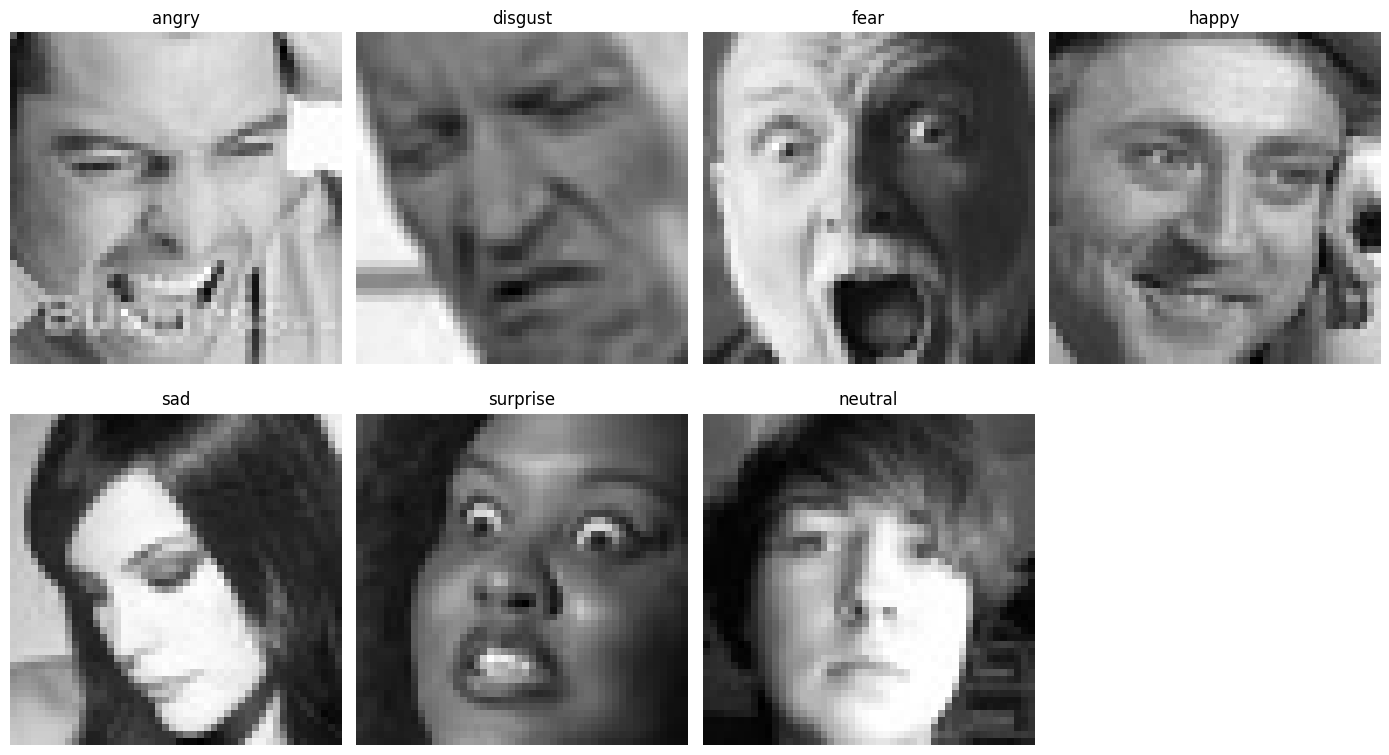

In [12]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Emotion classes
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Show one random image from each class
plt.figure(figsize=(14, 8))

for idx, emotion in enumerate(emotion_labels):
    folder = f'fer2013/train/{emotion}'
    image_name = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, image_name)

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import torchvision.transforms as T

transform = T.Compose([
    T.Grayscale(num_output_channels=3),      # Convert to 3-channel
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder('fer2013/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

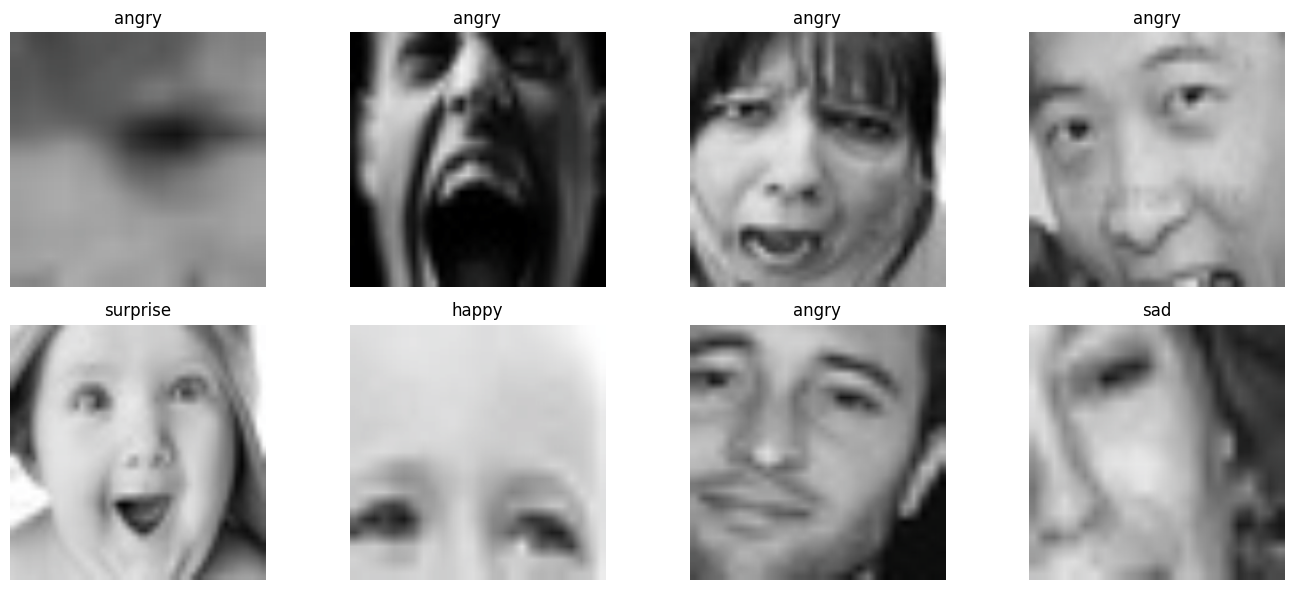

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get one batch
images, labels = next(iter(train_loader))

# Unnormalize to display
def unnormalize(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    return np.clip(img, 0, 1)

# Plot images
plt.figure(figsize=(14, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = unnormalize(images[i].cpu())
    plt.imshow(img)
    plt.title(train_dataset.classes[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


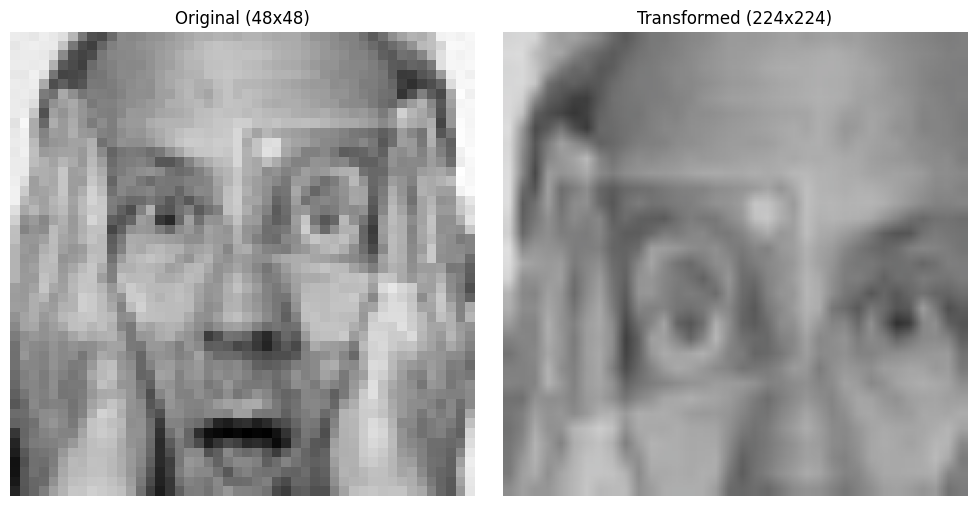

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import random
import os
import numpy as np

# Load a random image path from one of the classes
emotion = random.choice(os.listdir('fer2013/train'))
image_file = random.choice(os.listdir(f'fer2013/train/{emotion}'))
image_path = f'fer2013/train/{emotion}/{image_file}'

# Load original image using PIL
original_img = Image.open(image_path).convert('L')  # grayscale

# Define augmentation transforms (same as training)
transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(p=1.0),  # force it to flip
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

# Apply transform and unnormalize
transformed_img = transform(original_img)
def unnormalize(tensor):
    img = tensor.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return np.clip((std * img + mean), 0, 1)

transformed_img_np = unnormalize(transformed_img)

# Plot both
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original (48x48)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_img_np)
plt.title('Transformed (224x224)')
plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Train transforms (with augmentations)
train_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

# Val/test transforms (no augmentations)
val_test_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageFolder('fer2013/train', transform=train_transform)
val_dataset = ImageFolder('fer2013/val', transform=val_test_transform)
test_dataset = ImageFolder('fer2013/test', transform=val_test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Confirm class names
print("Classes:", train_dataset.classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [18]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device setup (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load ResNet-18 with pretrained weights
model = models.resnet18(pretrained=True)

# Freeze earlier layers (optional for faster training)
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier (FC layer) to match our 7 emotions
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7)  # 7 output classes

# Send model to device
model = model.to(device)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [19]:
# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Only optimize the final layer
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [20]:
import time

num_epochs = 20
best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()

    # Training mode
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # Validation mode
    model.eval()
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_fer_resnet18.pth')

    # Update LR
    scheduler.step()

    # Logging
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Time: {time.time() - start_time:.1f}s")


Epoch [1/20] Train Loss: 1.7343, Train Acc: 0.2983, Val Acc: 0.3351, Time: 100.7s
Epoch [2/20] Train Loss: 1.6670, Train Acc: 0.3378, Val Acc: 0.3943, Time: 97.5s
Epoch [3/20] Train Loss: 1.6499, Train Acc: 0.3497, Val Acc: 0.4040, Time: 97.6s
Epoch [4/20] Train Loss: 1.6445, Train Acc: 0.3493, Val Acc: 0.3863, Time: 81.6s
Epoch [5/20] Train Loss: 1.6383, Train Acc: 0.3520, Val Acc: 0.3950, Time: 81.1s
Epoch [6/20] Train Loss: 1.6378, Train Acc: 0.3508, Val Acc: 0.3950, Time: 81.2s
Epoch [7/20] Train Loss: 1.6345, Train Acc: 0.3529, Val Acc: 0.4033, Time: 82.3s
Epoch [8/20] Train Loss: 1.6337, Train Acc: 0.3535, Val Acc: 0.3999, Time: 81.1s
Epoch [9/20] Train Loss: 1.6352, Train Acc: 0.3506, Val Acc: 0.4086, Time: 81.4s
Epoch [10/20] Train Loss: 1.6286, Train Acc: 0.3587, Val Acc: 0.3908, Time: 81.7s
Epoch [11/20] Train Loss: 1.6061, Train Acc: 0.3672, Val Acc: 0.4047, Time: 97.6s
Epoch [12/20] Train Loss: 1.5997, Train Acc: 0.3684, Val Acc: 0.4086, Time: 96.6s
Epoch [13/20] Train Loss

In [21]:
train_losses = []
train_accuracies = []
val_accuracies = []

In [22]:
train_losses.append(train_loss)
train_accuracies.append(train_acc)
val_accuracies.append(val_acc)

Epoch [1/20] Loss: 1.5960, Train Acc: 0.3706, Val Acc: 0.4103, Time: 84.5s
Epoch [2/20] Loss: 1.5925, Train Acc: 0.3738, Val Acc: 0.4131, Time: 98.6s
Epoch [3/20] Loss: 1.5983, Train Acc: 0.3720, Val Acc: 0.4134, Time: 96.2s
Epoch [4/20] Loss: 1.5887, Train Acc: 0.3770, Val Acc: 0.4117, Time: 96.6s
Epoch [5/20] Loss: 1.5949, Train Acc: 0.3693, Val Acc: 0.4124, Time: 97.1s
Epoch [6/20] Loss: 1.5974, Train Acc: 0.3705, Val Acc: 0.4169, Time: 97.8s
Epoch [7/20] Loss: 1.5977, Train Acc: 0.3689, Val Acc: 0.4169, Time: 95.9s
Epoch [8/20] Loss: 1.5950, Train Acc: 0.3699, Val Acc: 0.4107, Time: 96.8s
Epoch [9/20] Loss: 1.5985, Train Acc: 0.3696, Val Acc: 0.4124, Time: 98.2s
Epoch [10/20] Loss: 1.5976, Train Acc: 0.3661, Val Acc: 0.4082, Time: 97.6s
Epoch [11/20] Loss: 1.5942, Train Acc: 0.3720, Val Acc: 0.4145, Time: 97.0s
Epoch [12/20] Loss: 1.5935, Train Acc: 0.3721, Val Acc: 0.4197, Time: 96.3s
Epoch [13/20] Loss: 1.5905, Train Acc: 0.3724, Val Acc: 0.4117, Time: 80.6s
Epoch [14/20] Loss: 1

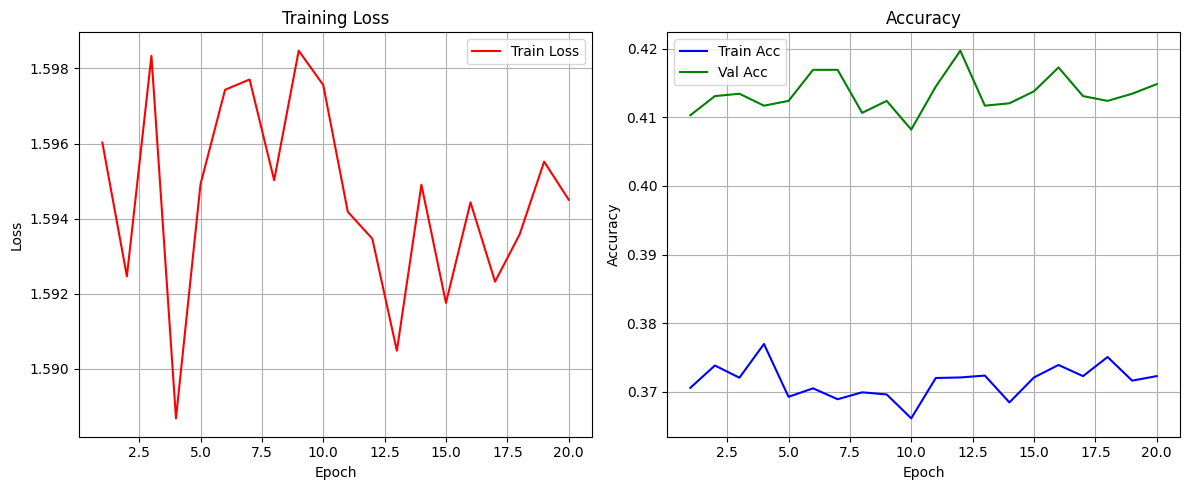

In [23]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Reinitialize model & optimizer if needed (optional)
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 7)
# model = model.to(device)
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()

num_epochs = 20
best_val_acc = 0.0

# Metrics
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_fer_resnet18.pth")

    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print log
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Time: {time.time() - start_time:.1f}s")

# Plot Loss & Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', color='blue')
plt.plot(epochs, val_accuracies, label='Val Acc', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

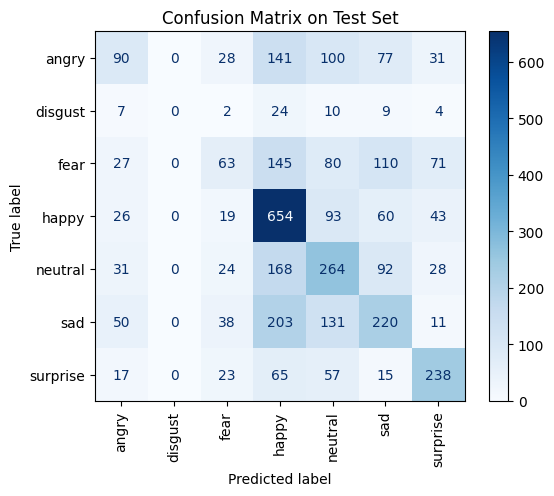

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model
model.load_state_dict(torch.load("best_fer_resnet18.pth"))
model.eval()

# Initialize lists to collect predictions and ground truths
all_preds = []
all_labels = []

# Run inference on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  # ['angry', 'disgust', ..., 'neutral']

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()


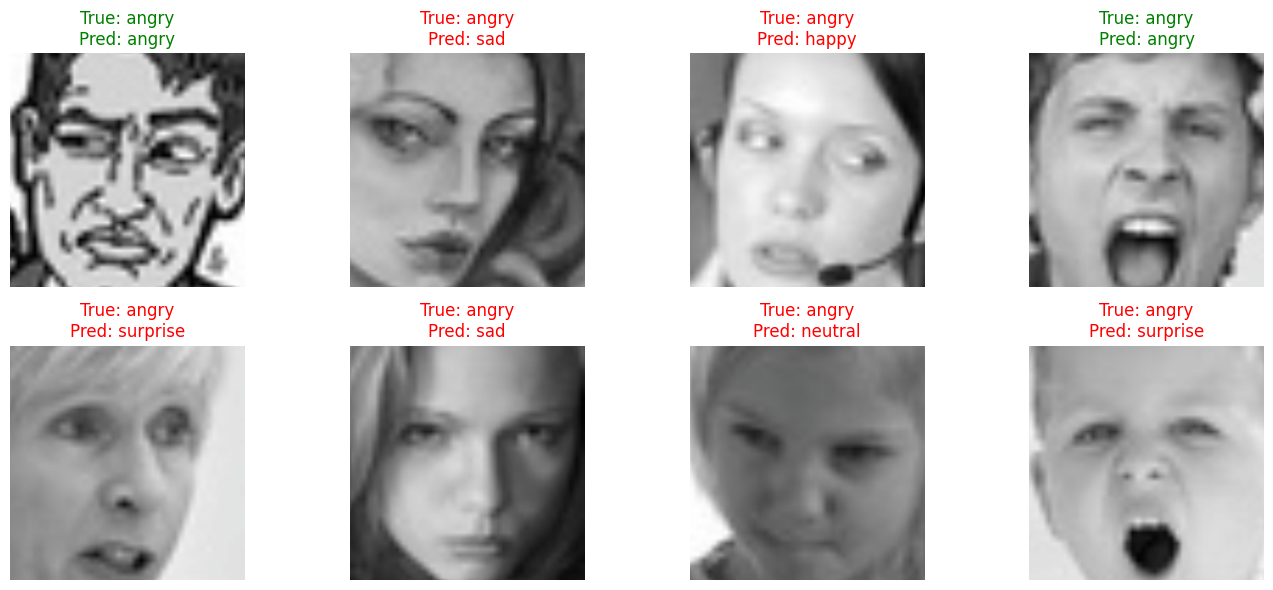

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Load best model (just in case)
model.load_state_dict(torch.load("best_fer_resnet18.pth"))
model.eval()

# Get one batch from the test set
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Class labels
class_names = train_dataset.classes

# Helper to unnormalize and convert image for plotting
def unnormalize(tensor):
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    return np.clip(img, 0, 1)

# Plot first 8 images from the batch
plt.figure(figsize=(14, 6))
for i in range(8):
    img = unnormalize(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color="green" if true_label == pred_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
!pip install gradio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00


In [28]:
import gradio as gr
from PIL import Image
import torchvision.transforms as T

# Load model
model.load_state_dict(torch.load("best_fer_resnet18.pth"))
model.eval()

# Classes
class_names = train_dataset.classes

# Transforms (same as test transforms)
transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

# Inference function
def predict_emotion(img):
    img = img.convert('L')  # grayscale
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    return class_names[pred]


In [29]:
iface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Facial Emotion Recognition",
    description="Upload a facial image (grayscale or color) to classify its emotion."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8431549a48e5f02420.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
